<a href="https://colab.research.google.com/github/carlm451/Gemstone_Images_Classification_Fine_Tuning/blob/main/Gemstones_Classifier_Model_Fine_Tuning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers

import numpy as np

import os
import matplotlib.pyplot as plt
from random import shuffle 

In [2]:
# pulling gemstones data from kaggle
#!pip install kaggle

!mkdir ~/.kaggle

#need a kaggle API key kaggle.json
!mv kaggle.json ~/.kaggle
! chmod 600 ~/.kaggle/kaggle.json

mkdir: cannot create directory ‘/root/.kaggle’: File exists
mv: cannot stat 'kaggle.json': No such file or directory


In [3]:
!ls ~/.kaggle

kaggle.json


In [4]:
!kaggle datasets download lsind18/gemstones-images

gemstones-images.zip: Skipping, found more recently modified local copy (use --force to force download)


In [5]:
!unzip gemstones-images.zip &> /dev/null
!ls 

gemstones-images.zip  sample_data  test  train	training_1  training_2	val


In [6]:
!mkdir val

mkdir: cannot create directory ‘val’: File exists


In [7]:
import os

data_dir = '/content'

train_dir = os.path.join(data_dir,'train')

val_dir = os.path.join(data_dir,'val')

test_dir = os.path.join(data_dir,'test')

def count_img_samples(directory):
    
    count = 0
    
    for i,gem_type in enumerate(os.listdir(directory)):
        
        gem_dir = os.path.join(directory,gem_type)
    
        img_list = os.listdir(gem_dir)

        #print(f' dir {gem_dir} has {len(img_list)} images')

        count += len(img_list)
    
    return count

n_train = count_img_samples(train_dir)
n_test = count_img_samples(test_dir)
n_val = count_img_samples(val_dir)

print(f'{n_train=}, {n_val=}, {n_test=}')

n_train=2434, n_val=422, n_test=363


In [8]:
from random import shuffle

def partition_val_data(train_dir,val_dir,val_split=0.1):
    
    for gem_type in os.listdir(train_dir):
        
        train_gem_dir = os.path.join(train_dir,gem_type)
        
        img_list = os.listdir(train_gem_dir)
        
        shuffle(img_list)
        
        n_samples = round(len(img_list)*val_split)
        
        val_img_list = img_list[:n_samples] # take n_samples random images to move
        
        val_gem_dir = os.path.join(val_dir,gem_type)
        
        if not os.path.exists(val_gem_dir):
            
            os.mkdir(val_gem_dir)
            
            for gem_img in val_img_list:
                
                original_path = os.path.join(train_gem_dir,gem_img)
                
                destination_path = os.path.join(val_gem_dir,gem_img)
                
                os.rename(original_path,destination_path)
        
            print(f'Moved {len(os.listdir(val_gem_dir))} training images from to {val_gem_dir}')
            
        else:
            
            print(f'Val dir {val_gem_dir} has {len(os.listdir(val_gem_dir))} images')

In [9]:
val_split=0.15  # move 15% train to use for validation

partition_val_data(train_dir,val_dir,val_split)

Val dir /content/val/Onyx Red has 4 images
Val dir /content/val/Alexandrite has 5 images
Val dir /content/val/Quartz Rose has 5 images
Val dir /content/val/Quartz Lemon has 5 images
Val dir /content/val/Almandine has 5 images
Val dir /content/val/Peridot has 6 images
Val dir /content/val/Diaspore has 5 images
Val dir /content/val/Serpentine has 4 images
Val dir /content/val/Quartz Rutilated has 6 images
Val dir /content/val/Spodumene has 5 images
Val dir /content/val/Chrysoprase has 4 images
Val dir /content/val/Morganite has 5 images
Val dir /content/val/Opal has 5 images
Val dir /content/val/Emerald has 5 images
Val dir /content/val/Garnet Red has 5 images
Val dir /content/val/Zoisite has 4 images
Val dir /content/val/Diamond has 5 images
Val dir /content/val/Onyx Black has 4 images
Val dir /content/val/Jade has 4 images
Val dir /content/val/Citrine has 6 images
Val dir /content/val/Bixbite has 5 images
Val dir /content/val/Pyrope has 5 images
Val dir /content/val/Quartz Beer has 5 i

In [10]:
!ls val

gem_types_list = os.listdir(val_dir)

n_classes = len(gem_types_list)

print(f'{n_classes} classes of gemstone')

 Alexandrite	      Chrysocolla     Larimar		 'Sapphire Blue'
 Almandine	      Chrysoprase     Malachite		 'Sapphire Pink'
 Amazonite	      Citrine	      Moonstone		 'Sapphire Purple'
 Amber		      Coral	      Morganite		 'Sapphire Yellow'
 Amethyst	      Danburite      'Onyx Black'	  Scapolite
 Ametrine	      Diamond	     'Onyx Green'	  Serpentine
 Andalusite	      Diaspore	     'Onyx Red'		  Sodalite
 Andradite	      Dumortierite    Opal		  Spessartite
 Aquamarine	      Emerald	      Pearl		  Sphene
'Aventurine Green'    Fluorite	      Peridot		  Spinel
'Aventurine Yellow'  'Garnet Red'     Prehnite		  Spodumene
 Benitoite	      Goshenite       Pyrite		  Sunstone
'Beryl Golden'	      Grossular       Pyrope		  Tanzanite
 Bixbite	      Hessonite      'Quartz Beer'	 'Tigers Eye'
 Bloodstone	      Hiddenite      'Quartz Lemon'	  Topaz
'Blue Lace Agate'     Iolite	     'Quartz Rose'	  Tourmaline
 Carnelian	      Jade	     'Quartz Rutilated'   Tsavorite
'Cats Eye'	      Jasper	     'Quartz 

In [11]:
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

mobilenet_V2_pretrained = MobileNetV2(include_top=False, pooling='avg',input_shape=(224,224,3))

for layer in mobilenet_V2_pretrained.layers:
    layer.trainable=False

mobilenet_V2_pretrained.summary()

Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 112, 112, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 112, 112, 32  128         ['Conv1[0][0]']                  
                                )                                              

In [12]:
import numpy as np

from tensorflow.keras.utils import load_img, img_to_array

def get_img_array(directory,gem_type):
    
    gem_dir = os.path.join(directory,gem_type)
    
    img_list = os.listdir(gem_dir)
    
    #shuffle(img_list)
    
    img_path = os.path.join(gem_dir,img_list[0])
    
    img = load_img(img_path)
    
    x = img_to_array(img) / 255.
    
    return x

def get_img_array_resized(directory,gem_type):
    
    gem_dir = os.path.join(directory,gem_type)
    
    img_list = os.listdir(gem_dir)
    
    #shuffle(img_list)
    
    img_path = os.path.join(gem_dir,img_list[0])
    
    img = load_img(img_path,target_size=(224,224),keep_aspect_ratio=True)
    
    x = img_to_array(img) / 255.
    
    return x

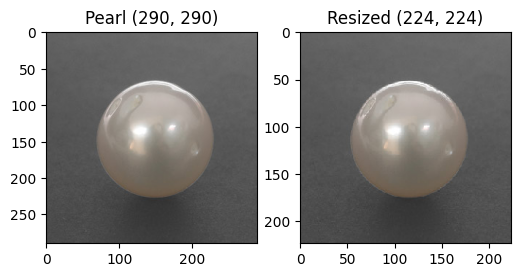

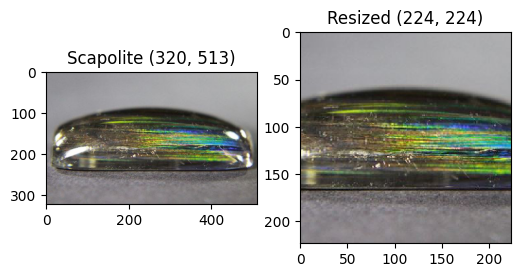

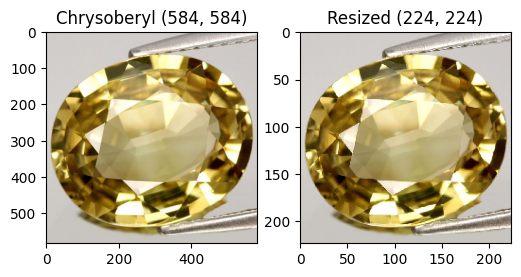

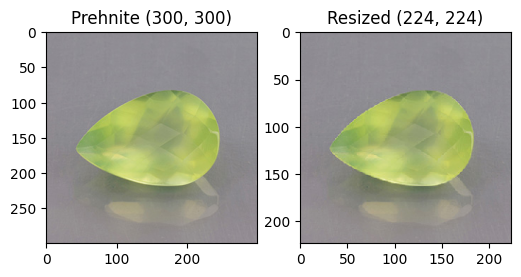

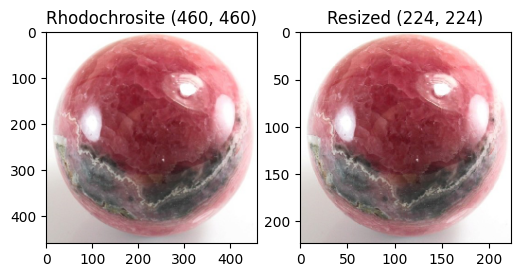

In [13]:
import matplotlib.pyplot as plt

shuffle(gem_types_list)

for gem_type in gem_types_list[:5]:

    sample_x = get_img_array(train_dir,gem_type)

    sample_x_resized = get_img_array_resized(train_dir,gem_type)

    fix, (ax1,ax2) =plt.subplots(1,2,figsize=(6,6))

    ax1.imshow(sample_x)
    ax1.set_title(f'{gem_type} {sample_x.shape[:2]}')

    ax2.imshow(sample_x_resized)
    ax2.set_title(f'Resized {sample_x_resized.shape[:2]}')

    plt.show()

In [14]:
# generators to stream images for training/validation
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale = 1.0/255.,
                                   rotation_range=90,
                                   width_shift_range=0.3,
                                   height_shift_range=0.3,
                                   zoom_range=0.4,
                                   horizontal_flip=True,
                                   vertical_flip=True
                                  )

val_datagen  = ImageDataGenerator( rescale = 1.0/255. )

train_generator = train_datagen.flow_from_directory(train_dir,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(224, 224),
                                                    keep_aspect_ratio='True',
                                                    classes=gem_types_list) 

val_generator = val_datagen.flow_from_directory(val_dir,
                                                    batch_size=64,
                                                    class_mode='categorical',
                                                    target_size=(224,224),
                                                    keep_aspect_ratio='True',
                                                    classes=gem_types_list) 

Found 2434 images belonging to 87 classes.
Found 422 images belonging to 87 classes.


In [15]:
def get_uncompiled_model(n_classes, pre_trained_model, model_name):

    model = tf.keras.models.Sequential(name=model_name)
    model.add(pre_trained_model)
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(n_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy', metrics=['accuracy'])
    
    return model

In [16]:
model = get_uncompiled_model(n_classes,mobilenet_V2_pretrained,'mobilenet_base_1')
    
model.summary()

model.input

Model: "mobilenet_base_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_224 (Funct  (None, 1280)             2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 87)                111447    
                                                                 
Total params: 2,369,431
Trainable params: 111,447
Non-trainable params: 2,257,984
_________________________________________________________________


<KerasTensor: shape=(None, 224, 224, 3) dtype=float32 (created by layer 'mobilenetv2_1.00_224_input')>

In [17]:
model.compile(optimizer=tf.keras.optimizers.Adam(0.005),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [18]:
!mkdir training_1

mkdir: cannot create directory ‘training_1’: File exists


In [ ]:
checkpoint_path = "training_1/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq='epoch')

history = model.fit(
            train_generator,
            epochs=8,
            validation_data=val_generator,
            verbose=1,
            callbacks=[cp_callback]
            )

Epoch 1/8
21/39 [===============>..............] - ETA: 14s - loss: 4.3101 - categorical_accuracy: 0.1373

In [ ]:
acc      = history.history[     'categorical_accuracy' ]
val_acc  = history.history[ 'val_categorical_accuracy' ]
loss     = history.history[    'loss' ]
val_loss = history.history['val_loss' ]

epochs   = np.arange(len(acc)) + 1 # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )

In [ ]:
os.listdir(checkpoint_dir)

In [ ]:
latest = tf.train.latest_checkpoint(checkpoint_dir)
latest #filename of the latest checkpoint

In [ ]:
# from manual inspection of val accuracy

best_epoch=5

best = os.path.join(checkpoint_dir,f'cp-{best_epoch:04d}.ckpt')
best

In [ ]:
mobilenet_V2_trainable = MobileNetV2(include_top=False, pooling='avg',input_shape=(224,224,3))

n_layers = len(mobilenet_V2_trainable.layers)

freeze_percent = 0.40

n_freeze = round(freeze_percent*n_layers)

for layer in mobilenet_V2_trainable.layers[:n_freeze]:
    layer.trainable=False

mobilenet_V2_trainable.summary()

In [ ]:
model_finetune = get_uncompiled_model(n_classes,mobilenet_V2_trainable,'mobilenet_finetune')
    
model_finetune.summary()

model_finetune.input

In [ ]:
!rm -r training_2

!mkdir training_2

In [ ]:
#start from checkpoint for best model 
model_finetune.load_weights(best)

model_finetune.compile(optimizer=tf.keras.optimizers.Adam(0.00001),
              loss=tf.keras.losses.CategoricalCrossentropy(),
              metrics = [tf.keras.metrics.CategoricalAccuracy()])

In [ ]:
class ValCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    '''
    Halts the training after reaching 60 percent accuracy

    Args:
      epoch (integer) - index of epoch (required but unused in the function definition below)
      logs (dict) - metric results from the training epoch
    '''

    # Check accuracy
    if(logs.get('categorical_accuracy') >= 0.85):

      # Stop if threshold is met
      print("\nReached 0.8 target training accuracy")
      self.model.stop_training = True

# Instantiate class
val_callback = ValCallback()

In [ ]:
checkpoint_path = "training_2/cp-{epoch:04d}.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1,
                                                 save_freq='epoch')

history_finetune = model_finetune.fit(
            train_generator,
            epochs=60,
            validation_data=val_generator,
            verbose=1,
            callbacks=[cp_callback,val_callback]
            )

In [ ]:
acc      = history_finetune.history['categorical_accuracy' ]
val_acc  = history_finetune.history['val_categorical_accuracy' ]
loss     = history_finetune.history['loss' ]
val_loss = history_finetune.history['val_loss' ]

epochs   = range(len(acc)) # Get number of epochs

#------------------------------------------------
# Plot training and validation accuracy per epoch
#------------------------------------------------
plt.plot  ( epochs,     acc )
plt.plot  ( epochs, val_acc )
plt.title ('Training and validation accuracy')
plt.figure()

#------------------------------------------------
# Plot training and validation loss per epoch
#------------------------------------------------
plt.plot  ( epochs,     loss )
plt.plot  ( epochs, val_loss )
plt.title ('Training and validation loss'   )